In [2]:
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

### Create Index

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embd = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorstore
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embd,
)
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


### LLMs

In [4]:
from typing import Literal
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""
    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore"
    )

llm = ChatGoogleGenerativeAI(model="models/gemini-2.5-flash-preview-05-20", temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

system = """You are an expert at routing a user question to a vectorestore or web search.
The vectorstore contains documents related to agents, prompt engineering, and aversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search. """
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}")
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke({"question", "who will the Bears draft first in the NFL draft?"})
)

print(question_router.invoke({"question": "What are the types of agent memory"}))

datasource='web_search'
datasource='vectorstore'


In [5]:
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

structured_llm_grader = llm.with_structured_output(GradeDocuments)
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question"""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}")
    ]
)
retrieval_grader = grade_prompt | structured_llm_grader
question = "Who is the real estate agent handling the property on Main Street?"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))


C:\Users\Tommy RAMAROKOTO\AppData\Local\Temp\ipykernel_6112\196823523.py:20: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


binary_score='no'


### Generate

In [6]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = prompt | llm | StrOutputParser()

generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

c:\Users\Tommy RAMAROKOTO\Documents\programmation\projects\New folder\chatbots\.venv\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


I apologize, but the provided context does not contain any information about a real estate agent handling a property on Main Street. The documents discuss LLM-powered autonomous agents and prompt engineering. Therefore, I cannot answer your question.


In [8]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""
    binary_score: str = Field(
        description="Answer is grounded in he facts, 'yes' or 'no'"
    )

structured_llm_hallucination_grader = llm.with_structured_output(GradeHallucinations)
system = """You are a grader assessing whether an LLM generation is grounde in / supported by a set of
retrieved facts. \n  Give a binary score 'yes' or 'no'. 'yes' means that the answer is grounded in / supported 
by a set of retrieved facts"""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}")
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_hallucination_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [9]:
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question"""
    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

structurered_llm_answer_grader = llm.with_structured_output(GradeAnswer)
system = """You are a grader assessing whether an answer addresses / resolves a question \n
    Give a binary score 'yes' or 'no'. 'yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}")
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeDocuments(binary_score='yes')

In [10]:
# Question re-writter

system = """You a question re-writer that converts an input question to a better version that is optimized \n
    for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning"""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Here is the initial question: \n\n {question} \n Formulate an improve question.")
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What is the name of the real estate agent responsible for the property located on Main Street?'

### Web search tool

In [11]:
from langchain_tavily import TavilySearch

web_search_tool = TavilySearch()


## Construct the Graph

In [12]:
# Define Graph state

from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes: 
        question: question
        generation: LLM generation
        documents: list of documents
    """
    question: str
    generation: str
    documents: List[str]
    

In [18]:
# Define Graph Flow
from langchain.schema import Document

def retrieve(state):
    """
    Retrieve documents

    Args: 
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state
    
    Returns: 
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args: 
        state (dict): The current graph state

    Returns: 
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args: 
        state (dict): The current graph state

    Returns: 
        state (dict): Updates question key with a re-phrased question
    """
    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

def web_search(state):
    """
    Web search based on the re-phrased question:

    Args: 
        state (dict): The current graph state

    Returns: 
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    question = state["question"]
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs["results"]])
    web_results = Document(page_content=web_results)
    return {"documents": web_results, "question": question}

def route_question(state):
    """
    Route question to web search or RAG
    Args:
        state (dict): The current graph state

    Returns: 
        str: Next node call
    """
    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args: 
        state (dict): The current graph state
    
    Returns:
        str: Binary decision for next node call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]
    if not filtered_documents:
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---")
        return "transfomr_query"
    else:
        print("---DECISION: GENERATE---")
        return "generate"
    
def grade_generation_v_documents_and_question(state):
    """
    Determines whethern the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Retuns:
        str: Decision for next node to call
    """
    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else: 
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [19]:
# Compile Graph

from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

workflow.add_node("web_search", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve"
    }
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate"
    }
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not usefule": "transform_query"
    }
)
app = workflow.compile()

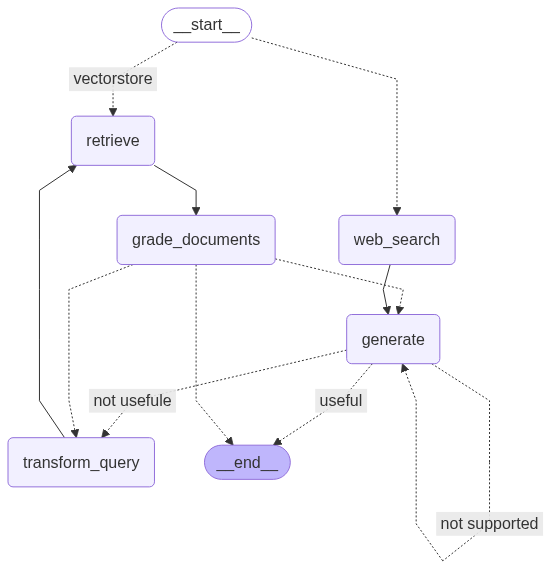

In [16]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [20]:
from pprint import pprint

# Run
inputs = {
    "question": "What player at the Bears expected to draft first in the 2024 NFL draft?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('The Chicago Bears were expected to draft Caleb Williams with the first '
 'overall pick in the 2024 NFL Draft. This was the consensus choice, and they '
 'ultimately selected the USC quarterback.')


In [21]:
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])


---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Agent memory includes short-term memory, which utilizes in-context learning, '
 'and long-term memory, which allows agents to retain and recall information '
 'over extended periods using an external vector store. Additionally, sensory '
 'memory is considered as learning embedding representations for raw inputs.')
